## NIEZBEDNE DO PONIZSZYCH

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import STL10, MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from typing import List, TypeVar
from tqdm import tqdm  # for progress bar
import numpy as np

from ssl_methods.beta_vae.components import ResNet18Decoder, ResNet18Encoder
from ssl_methods.beta_vae.b_vae import BetaVae


Tensor = TypeVar('torch.tensor')

In [56]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        with torch.no_grad():
            mu, log_var = self.encoder(x)  # Get the encoded features (mu)
        x = mu.view(mu.size(0), -1)  # Flatten
        x = self.fc(x)  # Apply the linear layer
        return x

# Load the labeled STL10 dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to match the input size for ResNet
    transforms.ToTensor()
])

labeled_dataset = STL10(root='./data', split='train', download=True, transform=transform)

# Split the labeled dataset into train and validation sets
train_size = int(0.8 * len(labeled_dataset))
val_size = len(labeled_dataset) - train_size
train_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = STL10(root='./data', split='test', download=True, transform=transform)

# Data loaders for labeled data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of loading a saved model
beta = 4
latent_dim = 64
model_filename = "beta_vae_beta_4.pth"

# Initialize the device
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")

# Load the BetaVae model
vae_model = BetaVae(beta=beta, in_channels=3, latent_dim=latent_dim).to(device)
vae_model.load_state_dict(torch.load(model_filename))
vae_model.eval()

# Freeze the encoder
for param in vae_model.encoder.parameters():
    param.requires_grad = False

# Create a classification model using the frozen encoder
classification_model = ClassificationModel(vae_model.encoder, num_classes=10).to(device)

# Check the output dimensions of the encoder
dummy_input = torch.randn(1, 3, 96, 96).to(device)
dummy_output, _ = vae_model.encoder(dummy_input)
print(f"Encoder output shape: {dummy_output.shape}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification_model.fc.parameters(), lr=1e-3)

# Train the classification model
num_epochs = 10
train_losses = []
val_losses = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correctly_classified = {i: [] for i in range(10)}
incorrectly_classified = {i: [] for i in range(10)}

for epoch in range(num_epochs):
    classification_model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (data, labels) in enumerate(pbar):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = classification_model(data)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        pbar.set_postfix({'Train Loss': train_loss / ((batch_idx + 1) * data.size(0))})
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    classification_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data, labels = data.to(device), labels.to(device)
            outputs = classification_model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for label, prediction, image in zip(labels, predicted, data):
                if label == prediction:
                    class_correct[label] += 1
                    correctly_classified[label.item()].append(image.cpu())
                else:
                    incorrectly_classified[label.item()].append(image.cpu())
                class_total[label] += 1
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Val Loss: {val_loss:.7f}, Val Accuracy: {val_accuracy:.2f}%')



Files already downloaded and verified
Files already downloaded and verified
Encoder output shape: torch.Size([1, 64])


Epoch 1/10: 100%|██████████| 125/125 [00:13<00:00,  9.41it/s, Train Loss=0.0708]


Epoch [1/10], Train Loss: 0.0708051, Val Loss: 0.0694658, Val Accuracy: 21.20%


Epoch 2/10: 100%|██████████| 125/125 [00:12<00:00,  9.63it/s, Train Loss=0.0667]


Epoch [2/10], Train Loss: 0.0667013, Val Loss: 0.0661446, Val Accuracy: 27.10%


Epoch 3/10: 100%|██████████| 125/125 [00:12<00:00, 10.04it/s, Train Loss=0.0641]


Epoch [3/10], Train Loss: 0.0640856, Val Loss: 0.0640464, Val Accuracy: 29.40%


Epoch 4/10: 100%|██████████| 125/125 [00:13<00:00,  9.42it/s, Train Loss=0.0623]


Epoch [4/10], Train Loss: 0.0623473, Val Loss: 0.0629328, Val Accuracy: 30.30%


Epoch 5/10: 100%|██████████| 125/125 [00:12<00:00,  9.72it/s, Train Loss=0.0612]


Epoch [5/10], Train Loss: 0.0611947, Val Loss: 0.0619114, Val Accuracy: 31.40%


Epoch 6/10: 100%|██████████| 125/125 [00:12<00:00,  9.80it/s, Train Loss=0.0603]


Epoch [6/10], Train Loss: 0.0602987, Val Loss: 0.0612024, Val Accuracy: 31.60%


Epoch 7/10: 100%|██████████| 125/125 [00:11<00:00, 10.50it/s, Train Loss=0.0595]


Epoch [7/10], Train Loss: 0.0595306, Val Loss: 0.0607149, Val Accuracy: 31.80%


Epoch 8/10: 100%|██████████| 125/125 [00:13<00:00,  9.46it/s, Train Loss=0.0591]


Epoch [8/10], Train Loss: 0.0591113, Val Loss: 0.0602957, Val Accuracy: 32.00%


Epoch 9/10: 100%|██████████| 125/125 [00:14<00:00,  8.85it/s, Train Loss=0.0587]


Epoch [9/10], Train Loss: 0.0587392, Val Loss: 0.0601597, Val Accuracy: 32.70%


Epoch 10/10: 100%|██████████| 125/125 [00:13<00:00,  9.01it/s, Train Loss=0.0584]


Epoch [10/10], Train Loss: 0.0583915, Val Loss: 0.0598705, Val Accuracy: 32.50%


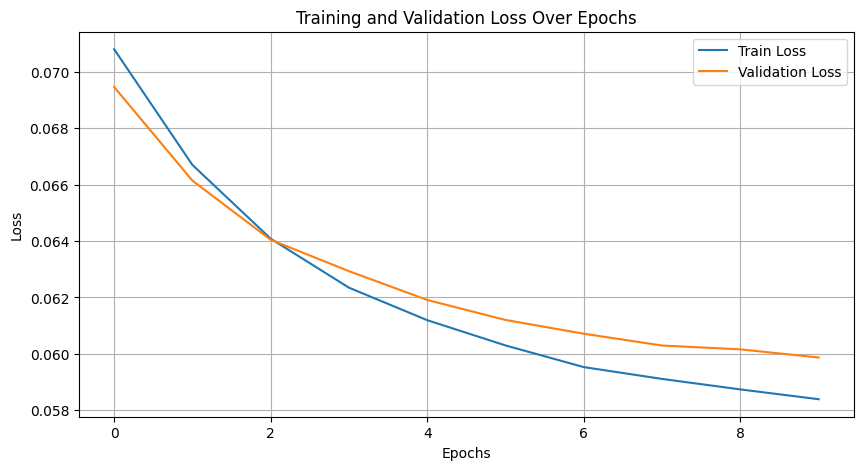

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Save the fine-tuned classification model
torch.save(classification_model.state_dict(), 'classification_model.pth')

Test Loss: 0.0586184, Test Accuracy: 32.99%, F1 Score: 0.31
Accuracy of class 0: 58.42%
Accuracy of class 1: 7.68%
Accuracy of class 2: 53.36%
Accuracy of class 3: 14.78%
Accuracy of class 4: 32.41%
Accuracy of class 5: 6.87%
Accuracy of class 6: 37.40%
Accuracy of class 7: 32.93%
Accuracy of class 8: 45.35%
Accuracy of class 9: 31.24%


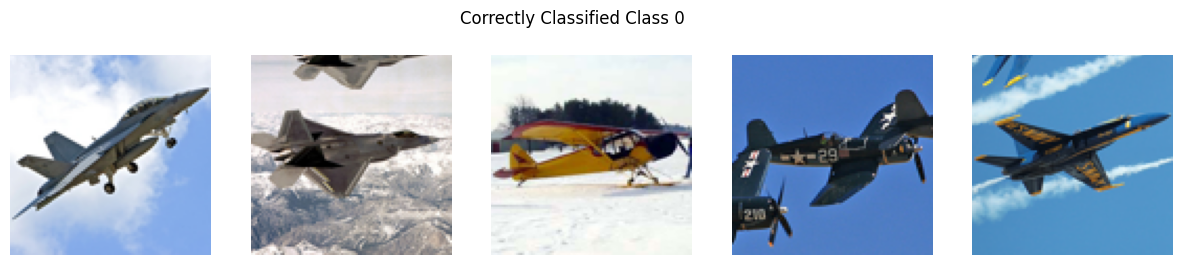

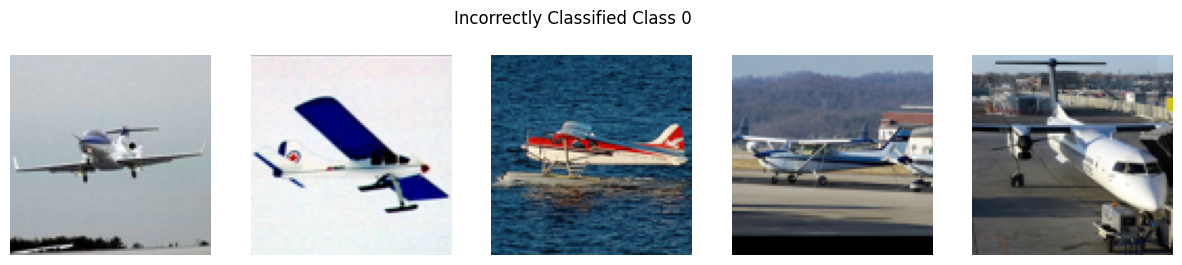

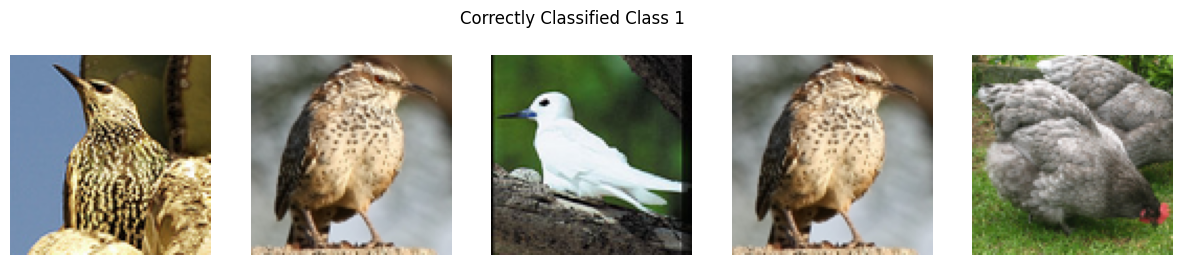

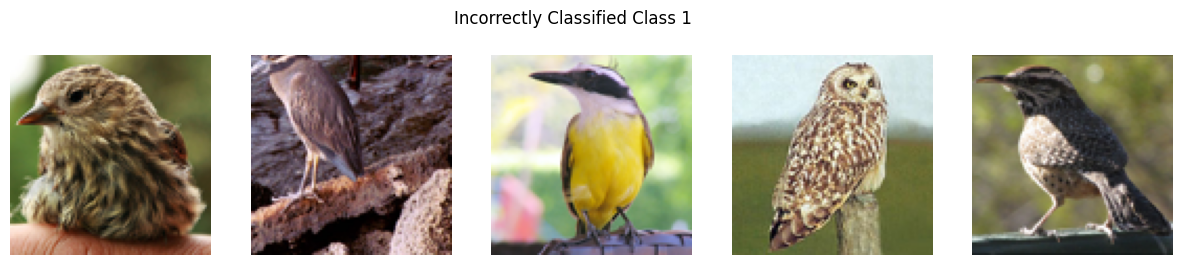

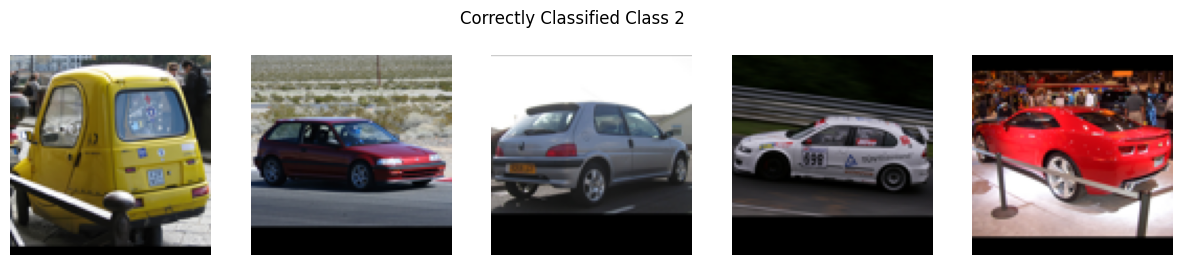

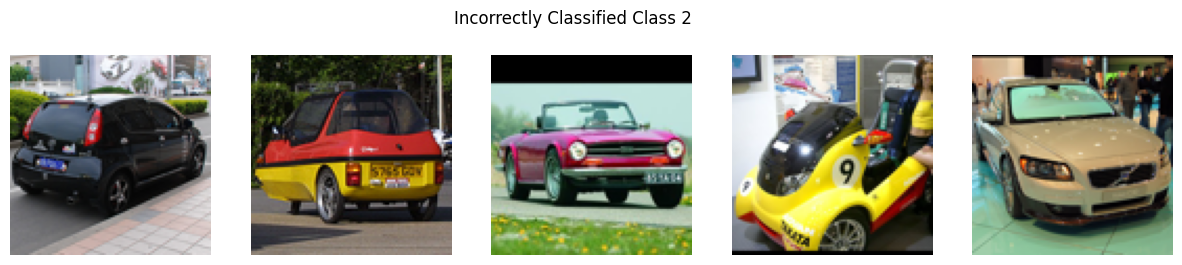

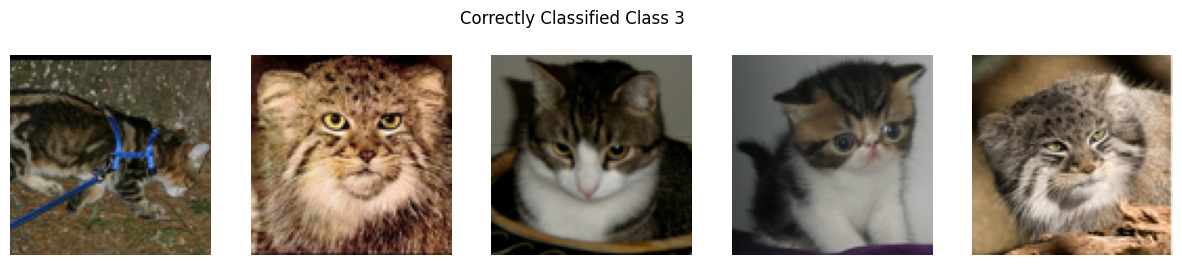

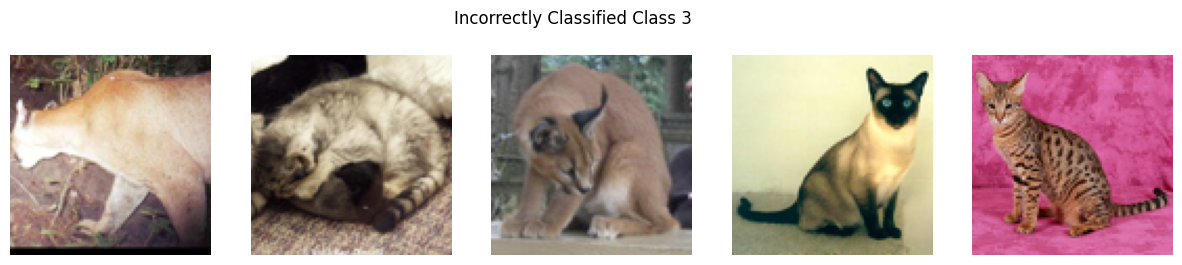

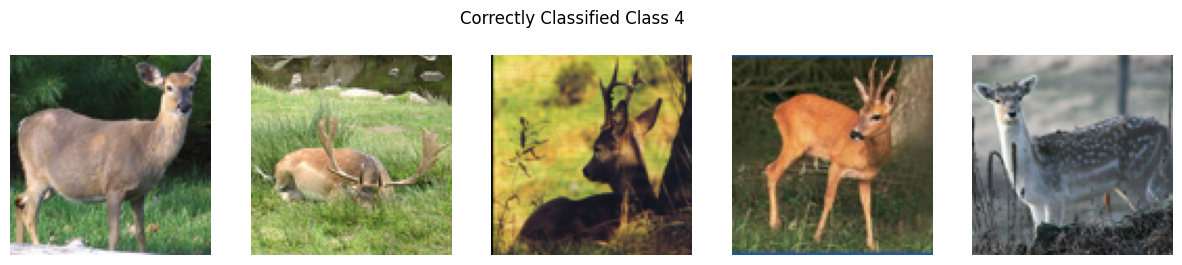

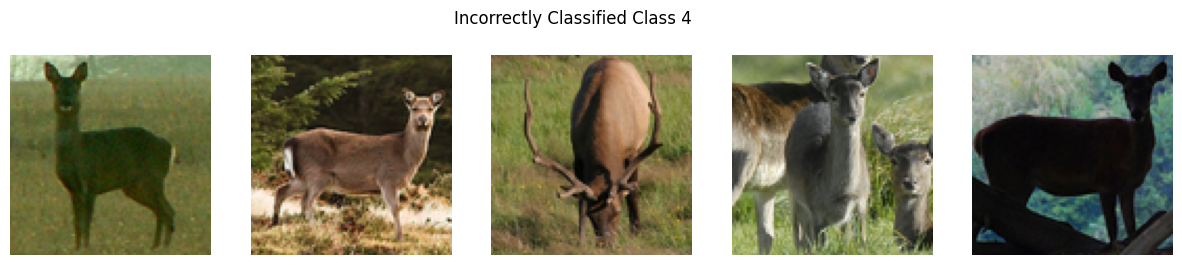

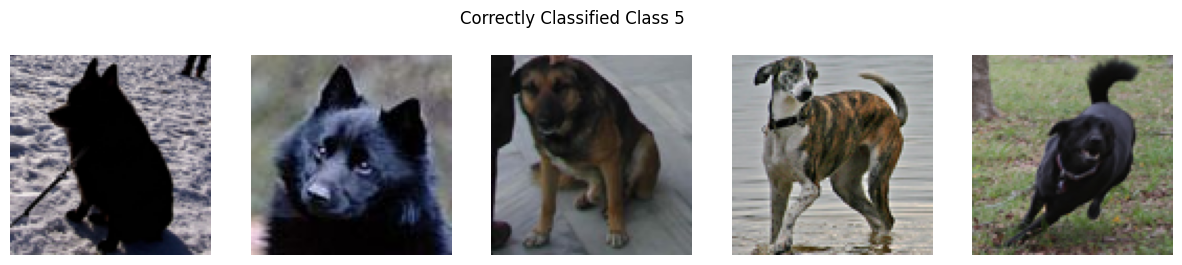

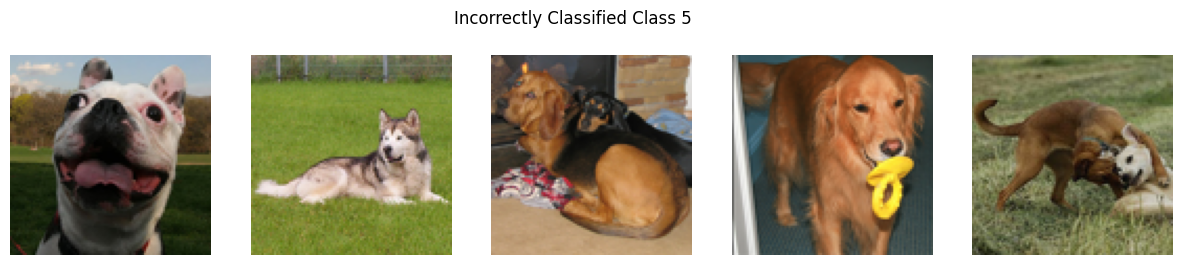

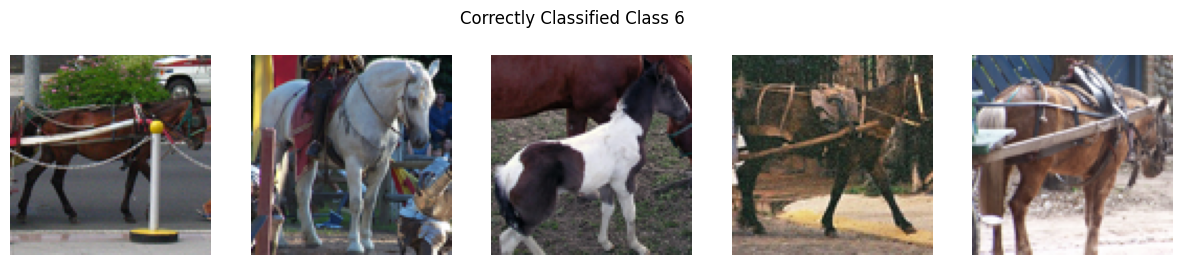

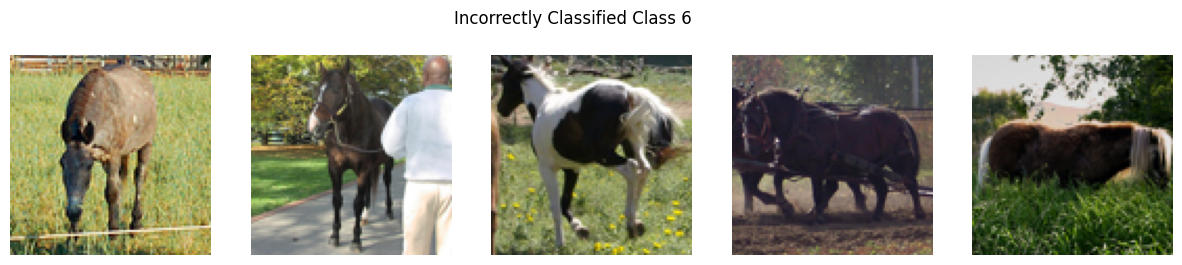

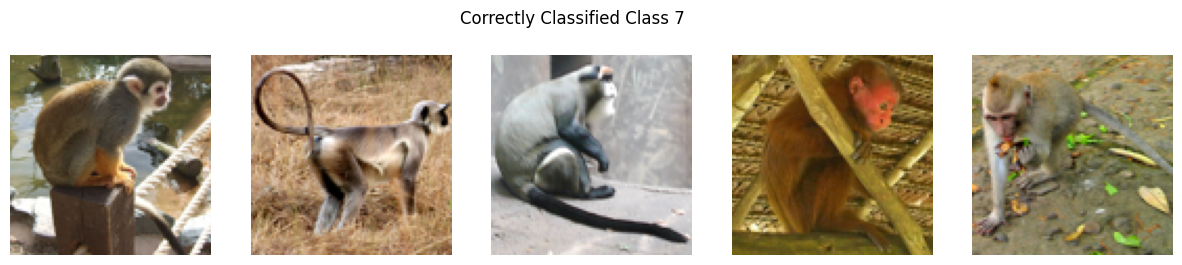

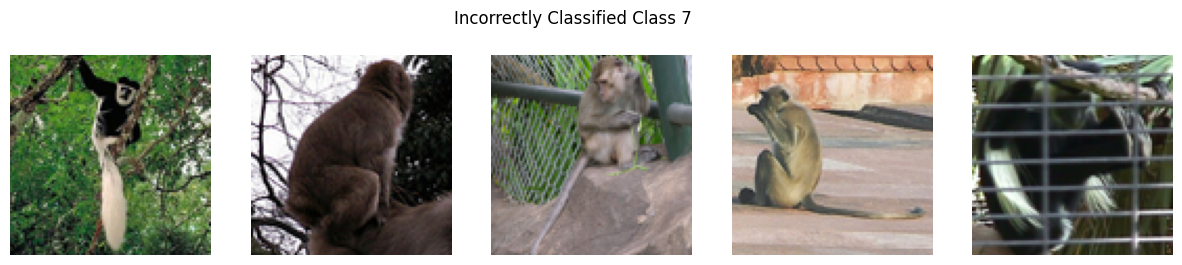

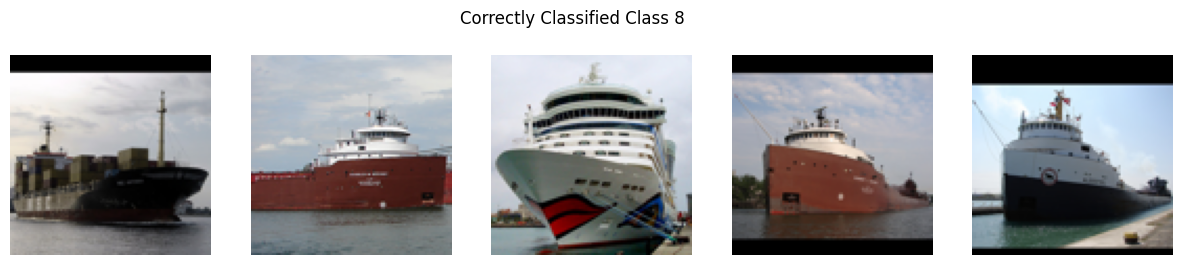

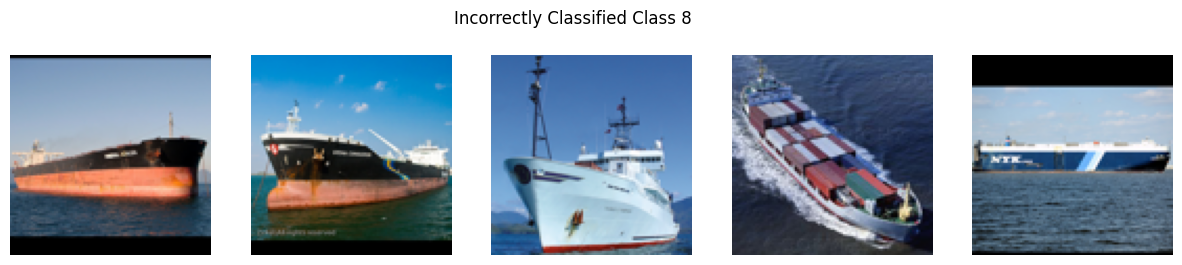

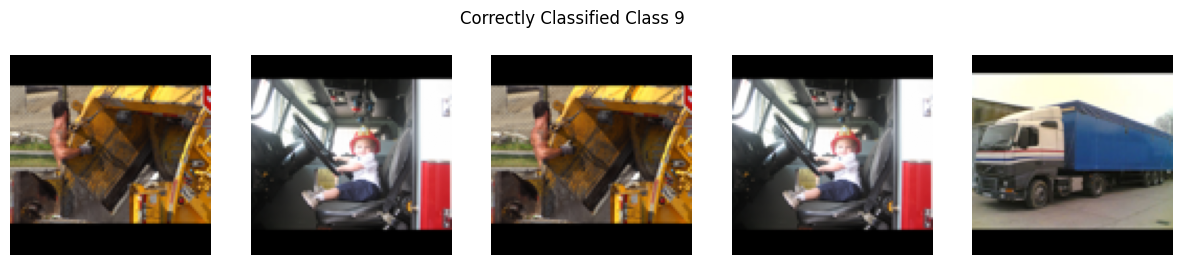

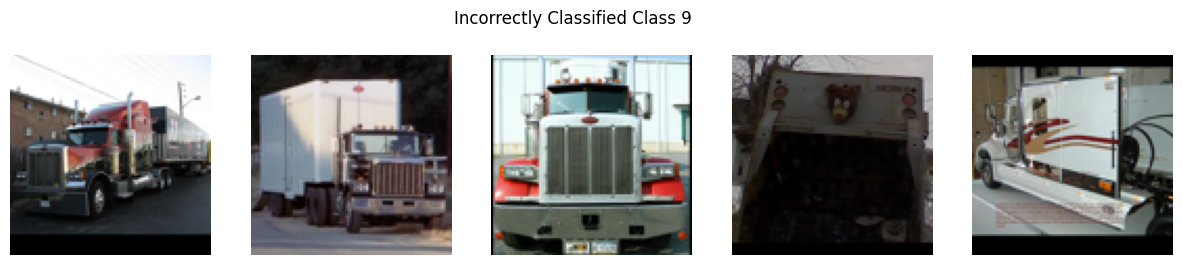

In [61]:
from sklearn.metrics import f1_score
classification_model.eval()
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = classification_model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        for label, prediction, image in zip(labels, predicted, data):
            if label == prediction:
                class_correct[label] += 1
                correctly_classified[label.item()].append(image.cpu())
            else:
                incorrectly_classified[label.item()].append(image.cpu())
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Test Loss: {test_loss:.7f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {f1:.2f}')

# Calculate and display class accuracy
for i in range(10):
    if class_total[i] > 0:
        print(f'Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Display examples of correctly and incorrectly classified images
def show_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for img, ax in zip(images, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

for i in range(10):
    if correctly_classified[i]:
        show_images(correctly_classified[i][:5], f'Correctly Classified Class {i}')
    if incorrectly_classified[i]:
        show_images(incorrectly_classified[i][:5], f'Incorrectly Classified Class {i}')

## Credible interval

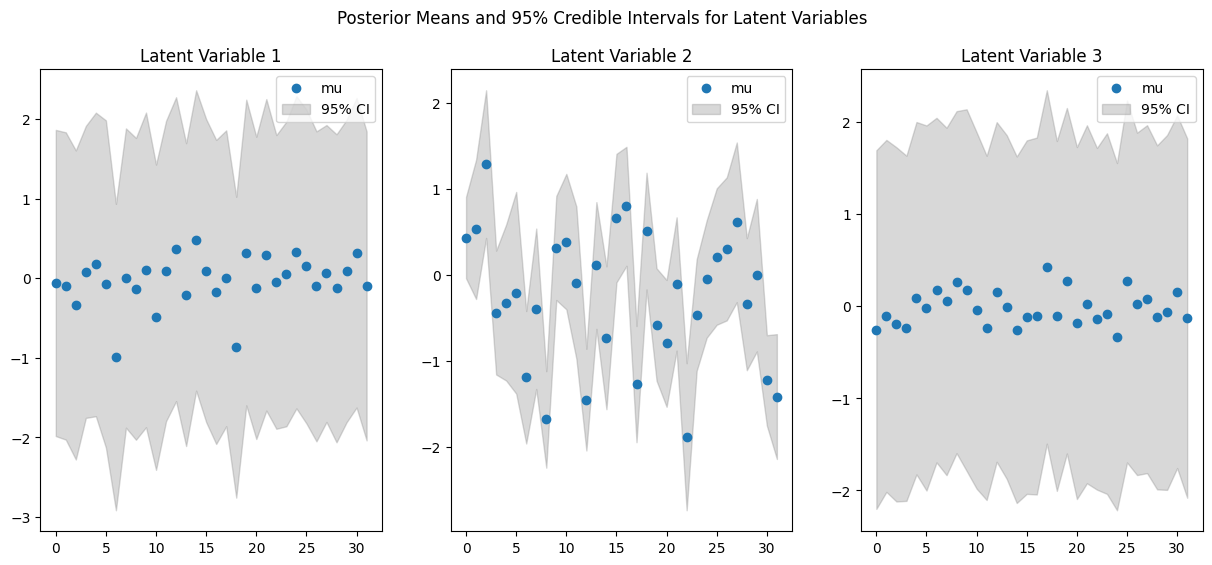

In [52]:
import torch
import matplotlib.pyplot as plt

# Load the BetaVae model and set it to evaluation mode
beta = 2
latent_dim = 64
model_filename = "beta_vae_beta_2.pth"

vae_model = BetaVae(beta=beta, in_channels=3, latent_dim=latent_dim).to(device)
vae_model.load_state_dict(torch.load(model_filename))
vae_model.eval()

# Select a batch of data
data_iter = iter(val_loader)
images, labels = next(data_iter)
images = images.to(device, dtype=torch.float32)

# Get the posterior distribution parameters from the encoder
with torch.no_grad():
    mu, log_var = vae_model.encoder(images)

# Compute standard deviation from log variance
std = torch.exp(0.5 * log_var)

# Compute the 95% credible intervals
credible_intervals = [(mu[:, i] - 1.96 * std[:, i], mu[:, i] + 1.96 * std[:, i]) for i in range(latent_dim)]

# Plot the credible intervals for a subset of latent variables (e.g., the first 5)
num_vars_to_plot = 3
fig, axes = plt.subplots(1, num_vars_to_plot, figsize=(15, 6))

for i in range(num_vars_to_plot):
    ci_lower, ci_upper = credible_intervals[i]
    mu_i = mu[:, i].cpu().numpy()
    ci_lower = ci_lower.cpu().numpy()
    ci_upper = ci_upper.cpu().numpy()
    
    ax = axes[i]
    ax.plot(mu_i, 'o', label='mu')
    ax.fill_between(range(len(mu_i)), ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
    ax.set_title(f'Latent Variable {i+1}')
    ax.legend()

plt.suptitle('Posterior Means and 95% Credible Intervals for Latent Variables')
plt.show()